<img align="left" width="32%" style="padding-right:10px;" src="Images/epom.png">


___
# Review of Linear Algebra
## 5 Solution of Nonlinear Equations

Jupyter Notebook Implementation: *Semme J. Dijkstra, 2022*

Original Linear Algebra text and in text examples: <br>*David E. Wells, Kresho Frankich, 1994*
___

<a href="https://teams.microsoft.com/l/team/19%3auL2OnH3RSfCWwU2Fd3VYGLT_03BYOfA3KB_OBp10CIY1%40thread.tacv2/conversations?groupId=5c11a428-14b6-429d-b7f5-a61ebc0a440b&tenantId=d6241893-512d-46dc-8d2b-be47e25f5666"><img src="Images/help.png"  title="Ask questions on Teams" align="right" width="10%" alt="Teams.com\"></a> 

Minor additional notes and edits: *Semme J. Dijkstra, 2022*<br>
Additional examples: *Semme J. Dijkstra, 2022*<br>
Python code and explanations: *Semme J. Dijkstra, 2022*
___

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sin, cos, sqrt, arctan
from scipy.ndimage.interpolation import rotate
import numpy.linalg as la
from my_code.latex_output import display_matrix, latex_matrix
from my_code.boat import boat
from my_code.set_limit import set_limit
from my_code.plottransform import plottransform
from IPython.display import display, Math, Markdown, Latex
%matplotlib notebook
from matplotlib.animation import FuncAnimation
%load_ext autoreload
%autoreload 2


___
<img align="left" width="6%" style="padding-right:10px;" src="./Images/info.png">

# LaTex<br>

This is a [Jupyter](https://jupyter.org/) notebook in which heavy use of [LaTex](https://www.latex-project.org/) is made. LaTex is *\"a high-quality typesetting system; it includes features designed for the production of technical and scientific documentation. LaTeX is the de facto standard for the communication and publication of scientific documents.\"* according to [the Latex project](https://www.latex-project.org/)

Latex allows the creation of macros and other type-setting methods of convenience. This particular Markdown cell you are reading is used for the definition of new LaTex operators and commands, but they are hidden from view. If you are interested: double click on this cell to enter its edit mode and you will be able see how they are implemented.

<div hidden>
$\usepackage{amsmath,amssymb}$

$\DeclareRobustCommand{\bbone}{\text{\usefont{U}{bbold}{m}{n}1}}$

$\DeclareMathOperator{\EX}{\mathbb{E}}% expected value$

$\DeclareMathOperator{\res}{\vec{r}}$

$\DeclareMathOperator{\mf}{\mu_{1}\sigma_{2}^{2}+\mu_{2}\sigma_{1}^{2}\over{\sigma_{1}^{2} + \sigma_{2}^{2}}}$
    
$\DeclareMathOperator{\sf}{{\sigma_{1}^{2}\sigma_{2}^{2}}\over{\sigma_{1}^{2}+\sigma_{2}^{2}}}$
    
$\newcommand{\ex}[1]{\mathbb{E}\{#1\}}$
    
$\newcommand{\dev}[1]{\mathbb{E}\{#1^o_i - \mathbb{E}\{#1\}\}}$
    
$\newcommand{\cov}[1]{\mathbb{E}\{(#1^o_i - \mathbb{E}\{#1\})(#1 - \mathbb{E}\{#1\})^T\}}$
    
$\newcommand{\m}[1]{\mathbf{#1}}$

$\newcommand{\col}[2]{\begin{pmatrix}#1 \\ #2 \end{pmatrix}}$
    
$\newcommand{\pd}[2]{\dfrac{\partial{\,#1}}{\partial{\,#2}}}$
    
</div>



___
# 5 The Solution of Nonlinear Equations

<img align="center" width="80%" style="padding-right:10px;" src="./Images/non_linear_lops.png">

In most cases, the equations and parameters that we use in Ocean Mapping are **not** linearly related. The figure above shows a situation in which we position a vessel located at $\m{x}_u$. The positioning is done by measuring ranges (distances) $l_i^o,  i\in\{1,2,3\}$ from a number of reference stations located at $\m{x}_i$. To make each observation $l_i^o$ the observer needs to be on a locus of points at which $l_i^o$ is valid. This locus is then, in this case, a circle centered on $\m{x}_i$ and is known as a ***Line of Position***, or more briefly an ***L.O.P.***. Given enough error-free observations, the intersection of the LOPs will determine the location of the vessel at $\m{x}_u$ uniquely. We may create an observation model for the LOPs and solve the problem mathematically.

<img align="center" width="80%" style="padding-right:10px;" src="./Images/linearized_lops.png">

In order to use the powerful tools that linear algebra provides we must find some way of ***linearizing*** the nonlinear equations i.e., replacing the non-linear equations by linear approximations as shown in the figure above. If you study the figure you will see that the linear approximations closely resemble the LOPs in the immediate vicinity of the location $\m{x}_u$, but they quickly diverge when moving away from $\m{x}_u$. Thus we require two things:

1. The $\m{x}_u$ at which we need to linearize the equations<br>
2. A method of deriving a set of linear equations at $\m{x}_u$

The first requirement poses a conundrum: to create a set of linear equations to solve for $\m{x}_u$, we need to know $\m{x}_u$ first! This may be addressed by using an initial estimate $\m{\hat{x}}_{u_0}$ and refining it through iteration. As you can see in the figure non-linear equations may lead to ambiguity e.g., the observations $l_2^o$ and $l_3^o$ intersect in two nearby locations, one of which is at the location $\m{x}_u$. The two corresponding solutions are mathematically equally valid, but only one represents reality! In this case the presence of observation $l_1^o$ allows the identification of the correct solution (disambiguation). To avoid convergence on a wrong solution you will need to 

1. Create an appropriate geometry of observations 
2. Devise a robust method of obtaining an initial estimate $\m{\hat{x}}_u$. 
3. Minimize the errors in observations

However, this is outside the scope of this discussion. This is a topic that will be addressed in the [Method of the Least Squares]() module.

The second requirement is more easily addressed, but we will need some results from the calculus of matrices in order to derive the set of linear equations. The assumption is made that you are familiar with the calculus, but not its implementation with matrices, thus a short introduction to the topic is provided.

Note that much may be said about the calculus of matrices. Here the scope of discussion is limited to what is required for the *method of the least squares* and *Kalman filtering*, both of which are routinely encountered in Ocean Mapping.


___

### 5. Self Study Exercise 1

- This exercise will develop throughout this Notebook - to avoid unwanted behavior due to code cells 
    being executed out of order you will be asked to copy the code from previous exercises to subsequent 
    exercises in this Notebook

Imagine that you are in a true location $\m{x}_{u}$ and are observing distances $l_i^o$ to three locations $\m{x}_i$. The locations and observations are given in the table below. In reality you make the distance observations to come up with an estimate $\m{\hat{x}_u}$ of $\m{x}_{u}$ and the observations $l_i^o$ will not exactly match the true distances $l_i$ from $\m{x}_i$ to $\m{x}_{u}$ due to observation errors (an even more realistic scenario would be to use $\m{\hat{x}_i}$ i.e., allowing for error in the locations $\m{x}_i$). 


$$\begin{array}{|c|c|c|c|} \text{Location}&\text{Easting}&\text{Northing}&\text{Observation} \\
\hline \\
\m{x}_{u} & 34682.29 & 198739.81 &   \\
\m{x}_{1} & 34589.76 & 198645.87 &  131.753 \\ 
\m{x}_{2} & 34857.20 & 198628.99 &  207.157 \\
\m{x}_{3} & 34624.74 & 198823.66 &  101.611 \\
\end{array}$$


1. In the code cell below define a parameter `t` ranging from $0$ to $2\pi$
2. Create a $2\times n$ `numpy` array `circle` holding the cosine of `t` on the first row and, the sine of `t` on the second
3. Create a $2\times 1$ `numpy` array `x_u` holding the Easting of $\m{x}_{u}$ on the first row, and the Northing on the second<br>
4. Similar to c) create a $2\times 3$ `numpy` array `x_i` holding the various $\m{x}_{i}$ in columns $i-1$ (remember Python indexing starts at 0)<br>
5. Create a $3\times 1$ `numpy` array `l_obs` holding the observations from $\m{x}_{1}$ on the first row, $\m{x}_{2}$, on the second, etc.  
6. Create the difference vectors $\m{x}_{u}-\m{x}_{u}$ by differencing and assign the result to `bl` (bl for baseline)
7. Create 

<IPython.core.display.Javascript object>


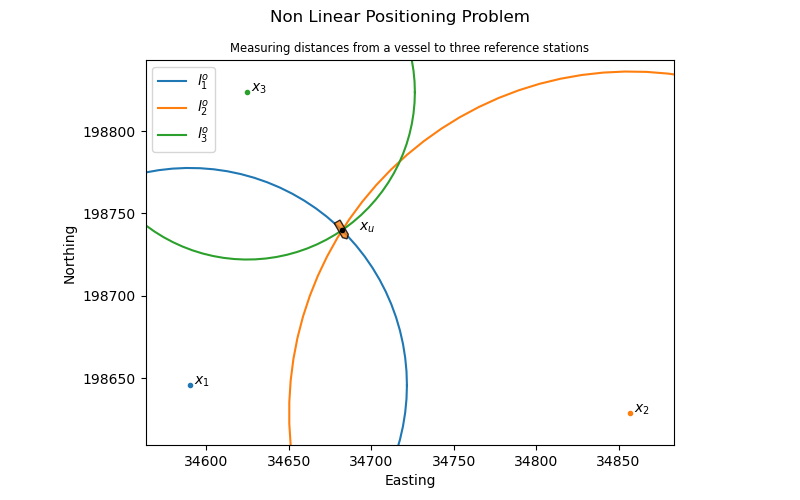

In [5]:
# Get a boat shape and some heading - note that we use the Scipy implementation of rotation matrices here
# This just so that you see that most of the Linear Algebra functionality is implemented in the scipy and 
# numpy modules
th = pi/3
B = np.asarray([[cos(th), sin(th)],[-sin(th),cos(th)]])@boat()
 
# a) define a parameter `t` ranging from $0$ to $2\pi$<br>
t = np.linspace(0,2*pi,100)

# b) Create `circle` holding the cos of `t` on the first row and sin of `t` on the second
circle = np.array([cos(t),sin(t)])

# c) Create `x_u` holding the Easting on the first row, and the Northing on the second.
x_u = np.array([[ 34682.29],[ 198739.81]])

# d) Similar to c) create `x_i` holding the various 𝐱𝑖 (remember Python indexing starts at 0)
x_i = np.array([[ 34589.76, 34857.20, 34624.74],[ 198645.87, 198628.99, 198823.66]])

# e) Create `l_obs` holding the Easting of 𝐱𝑢 on the first row, and the Northing on the second
l_obs = np.array([[131.753], [207.157], [101.611]])

# Determine the number of observations
n = len(l_obs)

# Create the baselines between the observer and the stations `x_i`
bl = x_u - x_i

# Allocate memory for the observable vector l
l = np.zeros((3,1))

# Model the observations
for i,b in enumerate(bl.T):
    l[i] = sqrt(b.T@b)
    
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

for i in range(n):
    c = 'C'+str(i%10)  # modulo 10 because there are only 10 available this way
    # Plot the reference stations x_i
    plt.plot(x_i[0,i],x_i[1,i],color = c, marker='.', linestyle='',zorder = 0)
    plt.text(x_i[0,i],x_i[1,i],' $x_%d$'%(i+1),color = 'k',zorder = 1)

    # Turn the observation into a Line of Position
    plt.plot(l[i]*circle[0,:]+x_i[0,i],l_obs[i]*circle[1,:]+x_i[1,i],zorder = 0, label = '$l_%d^o$'%(i+1))
    
# Plot and identify the true location 
plt.plot(x_u[0],x_u[1],color = 'k', marker='.', linestyle='',zorder = 2)
plt.text(x_u[0],x_u[1],'    $x_u$',color = 'k',zorder = 2)
plt.fill(B[0,:]+x_u[0],B[1,:]+x_u[1],'C1', ec='k', alpha=.8,zorder=0)

plot_limits = set_limit(np.column_stack((x_u,x_i)))
ax1.set_xlim(plot_limits[0])
ax1.set_ylim(plot_limits[1])
ax1.set_aspect('equal')
plt.suptitle('Non Linear Positioning Problem')
plt.title('Measuring distances from a vessel to three reference stations',size = 'small')
ax1.set_xlabel('Easting')
ax1.set_ylabel('Northing')
plt.legend()
plt.show()

___
## 5.1 Matrix Calculus

In these notebooks the elements of matrix $\m{A}$ have so-far been numbers. However, you may now assume that the elements of matrix $\m{A}$ are differentiable functions of a variable $x$ i.e., $a_{ij}=a_{ij}(x)$. Then the derivative of $\m{A}$ is defined as the matrix whose elements are the derivatives of the corresponding elements of $\m{A}$. 

For example, for

$$\m{A} = \begin{pmatrix} a_{11}(x) & a_{12}(x) \\ a_{21}(x) & a_{22}(x) \end{pmatrix}\tag{204}$$

the derivative of $\m{A}$ is

$$\dfrac{d\m{A}}{dx} = \begin{pmatrix} \dfrac{d\,a_{11}(x)}{dx} & \dfrac{d\,a_{12}(x)}{dx} \\ \\ \dfrac{d\,a_{21}(x)}{dx} & \dfrac{d\,a_{22}(x)}{dx} \end{pmatrix}\tag{205}$$

If $\m{A}$ is the product of two other matrices $\m{B}$ and $\m{C}$, whose elements are also differentiable functions of $x$, then
<a id='eq206'></a>
$$\m{A}=\m{BC}\tag{206}$$

has the derivative:

$$\dfrac{d\m{A}}{dx} = \dfrac{d\m{\,BC}}{dx} = \dfrac{d\m{\,B}}{dx}\m{C}+\m{B}\dfrac{d\m{C}}{dx}\tag{207}$$

if $\m{C}$ is nonsingular, it has an inverse and we find from [(206)](#eq206):

$$\m{B}=\m{AC}^{-1}\tag{208}$$

which may be differentiated as (by rewriting [(207)](#eq207))

$$\dfrac{d\m{\,B}}{dx}=\dfrac{d\m{AC}^{-1}}{dx}=\dfrac{d\m{A}}{dx}\m{C}^{-1}-\m{A}\m{C}^{-1}\dfrac{d\m{C}}{dx}\m{C}^{-1}\tag{209}$$

Note that [(207)](#eq207) and [(209)](#eq209) are analogous to the derivatives of $a(x) = b(x)c(x)$ and $b(x)=a(x)/b(x)$. However, because matrices are generally not commutative the order in [(207)](#eq207) and [(209)](#eq209) cannot be altered.

In the quadratic form

$$l^2 = \m{x}^T\m{Ax}\tag{210}$$

the elements of the matrix $\m{A}$ are considered as constants, and the elements of $\m{x}$ as variables. The derivative of the quadratic form is then

$$dl^2=d\m{x}^T\cdot\m{Ax}+\m{x}^T\m{A}\cdot d{\m{x}}\tag{211}$$

and if $\m{A}$ is symmetric ($\m{A}^T=\m{A}$) then (using [(44)](2_Matrix_Algebra.ipynb#eq44): $(\m{A}\m{B})^T = \m{B}^T\m{A}^T)$

$$dl^2=2\m{x}^T\m{A}\cdot d{\m{x}}\tag{212}$$

thus

$$\dfrac{d\m{x}^T\m{Ax}}{d\m{x}}=2\m{x}^T\m{A}\tag{213}$$

___
## 5.2 Partial Differentiation

Consider a column vector $\m{y}$ having $m$ elements, each of which is function of *several* variables $(x_1, x_2, \dots, x_n)$. Let $\m{x}$ be the column vector whose elements are these variables. If we adopt the convention that the derivatives of $y_1$ form a row vector, it has the form

$$\pd{y_1}{\m{x}}=\begin{pmatrix}\pd{y_1}{x_1}&\pd{y_1}{x_2}&\dots&\pd{y_1}{x_n}\end{pmatrix}\tag{214}$$

By this convention the derivative of the entire vector $\m{y}$ becomes an array

$$\pd{\m{y}}{\m{x}}=\begin{pmatrix}
\pd{y_1}{x_1}&\pd{y_1}{x_2}&\dots&\pd{y_1}{x_n} \\
\\
\pd{y_2}{x_1}&\pd{y_2}{x_2}&\dots&\pd{y_2}{x_n} \\
\vdots&\vdots&\ddots&\vdots \\
\pd{y_n}{x_1}&\pd{y_n}{x_2}&\dots&\pd{y_n}{x_n}\end{pmatrix}\tag{215}$$

the $(i,j)$ element of which is given by $\pd{y_i}{x_j}$. The total differential of $\m{y}$ is given by:

$$d\m{y} = \pd{\m{y}}{\m{x}}d\m{x}\tag{216}$$

where $d\m{y}$ and $d\m{x}$ are column vectors. When $\m{x}$ and $\m{y}$ have the same order the matrix $\pd{\m{y}}{\m{x}}$ and is called the ***Jakobian*** matrix of the transformation of $\m{x}$ into $\m{y}$. 


___
### 5.3 Taylor Series Linearization

Now that you have learned the fundamentals of the calculus of matrices we can address the problem of linearization, which we will do through the use of ***Taylor series***. A Taylor series is used to determine the value of function at a point, using an infinite series of terms containing the derivatives of the function.
Thus given a scalar function $f(x)$ of a scalar variable $x$, and a known value of this function $f(a)$ at $x=a$, then values of the function at other values of $x$ are given by Taylor's series:

$$f(x) = f(a)+\left.\pd{f}{x}\right|_{a}(x-a)+\left.\pd{^2f}{x^2}\right|_{a}\dfrac{(x-a)^2}{2!}+\left.\pd{^3f}{x^3}\right|_{a}\dfrac{(x-a)^3}{3!}+\cdots\tag{217}$$

If this series is truncated after the first derivative term a ***linear approximation*** of $f(x)$ in the neighborhood of the $x=a$ is achieved:

$$f(x)\approx f(a)+\left.\pd{f}{x}\right|_a(x-a)\tag{218}$$

<img align="center" width="80%" style="padding-right:10px;" src="./Images/linearized_lops.png">

Similarly, if a scalar function of a vector variable $\m{x}$, and its value $f(\m{a})$ is known at $\m{x}=\m{a}$, then for values $\m{x}$ close to $\m{a}$ the Taylor's series approximation is:

$$f(\m{x})\approx f(\m{a})+\left.\pd{f}{\m{x}}\right|_\m{a}\delta\tag{219}$$

where 

$$\delta=\m{x}-\m{a}\tag{220}$$

is a column vector, and

$$\pd{f}{\m{x}} = \begin{pmatrix}\pd{f}{x_1}&\pd{f}{x_2}&\dots&\pd{f}{x_n}\end{pmatrix} \tag{221}$$

is a row vector.

Finally, if we have several scalar functions of $\m{x}$, $f_1(\m{x}), f_2(\m{x}),\dots, f_m(\m{x})$ we can set a vector function $\m{f}$

$$\m{f}(\m{x}) = \begin{pmatrix} f_1(\m{x}) \\ f_2(\m{x}) \\ \dots \\ f_m(\m{x}) \end{pmatrix} \tag{222}$$

resulting in

$$\pd{\m{f}}{\m{x}} = \begin{pmatrix}
\pd{f_1}{x_1}&\pd{f_1}{x_2}&\dots&\pd{f_1}{x_n} \\ \\
\pd{f_2}{x_1}&\pd{f_2}{x_2}&\dots&\pd{f_2}{x_n} \\ \\
\vdots & \vdots & \ddots & \vdots \\ \\
\pd{f_m}{x_1}&\pd{f_m}{x_2}&\dots&\pd{f_m}{x_n}
\end{pmatrix}\tag{223}$$

For values $\m{x}$ close to $\m{a}$ may then obtain the Taylor's series approximation of the vector function $\m{f}(\m{x})$ if its value $f(\m{a})$ known at $\m{x}=\m{a}$ by:

$$\m{f}(\m{x})\approx \m{f}(\m{a})+\left.\pd{\m{f}}{\m{x}}\right|_\m{a}\delta\tag{224}$$

___
### 5.4 Application to Solution of Nonlinear Equations in Ocean Mapping

If we have a system of nonlinear homogeneous equations:

<a id='eq225'></a>
$$\m{f}(\m{x}) = \m{0}\tag{225}$$

We can use [(225)](#eq225) to approximate them by the system of linear equations:

$$\m{f}(\m{\hat{x}})+\left.\pd{\m{f}}{\m{x}}\right|_\m{\hat{x}}\delta=\m{0}\tag{226}$$

where $\m{\hat{x}}$ is the estimate of $\m{x}$ i.e., $\ex{\m{\hat{x}}}=\m{x}$ and, which is in the form:

<a id='eq227'></a>
$$\m{A}\hat\delta = \m{b}\tag{227}$$

where

<a id='eq228'></a>
$$\m{A} = \left.\pd{\m{f}}{\m{x}}\right|_\m{\hat{x}}\tag{228}$$

and

$$\m{b} = -\m{f}(\hat{\m{x}})\tag{229}$$ 

are both known, and the ***adjustment***

$$\hat\delta = \m{x}-\m{\hat{x}}\tag{230}$$

is unknown. We then procedd to find a solution for $\delta$, using the linear methods of [Notebook 3: Solution of Linear Equations](3_Solution_of_Linear_Equations.ipynb). However, since [(228)](#eq228) is an approximation to [(227)](#eq227), we often must set

$$\m{\hat{x}}_1 = \m{\hat{x}}_0+\hat\delta$$

then re-evaluate $\m{f}(\m{\hat{x}}_1) and 

___
### Useful Resources

[Learning Least Squares]()

[Gilbert Strang MIT video lecture series](https://ocw.mit.edu/courses/18-06-linear-algebra-spring-2010/video_galleries/video-lectures/)

___
## Jump to Chapter

[1: Introduction](1_Introduction.ipynb)<br>
[2: Matrix Algebra](2_Matrix_Algebra.ipynb)<br>
[3: Solution_of_Linear_Equations](3_Solution_of_Linear_Equations.ipynb)<br>
[4: Linear Transformations](4_Linear_Transformations.ipynb)<br>
[6: The Choleski Method](6_The_Choleski_Method.ipynb) <br>

___
#### Copyright 2022, Semme J. Dijkstra

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<IPython.core.display.Javascript object>


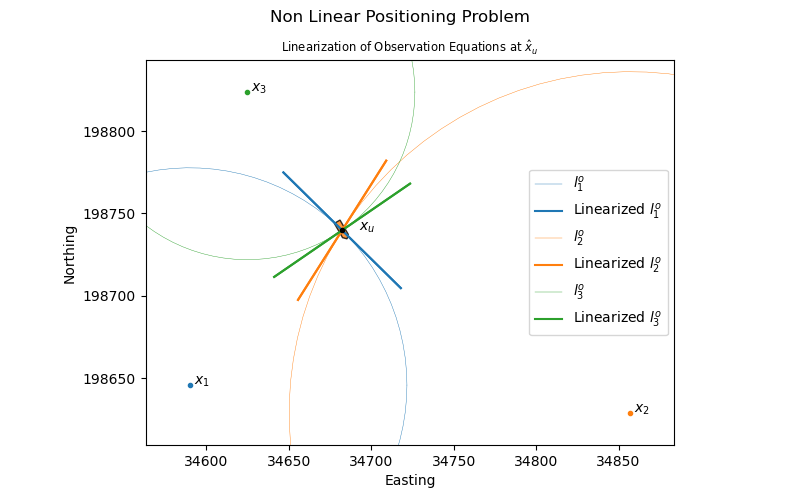

In [4]:
# Get a boat shape and some heading - note that we use the Scipy implementation of rotation matrices here
# This just so that you see that most of the Linear Algebra functionality is implemented in the scipy and 
# numpy modules
th = pi/3
B = np.asarray([[cos(th), sin(th)],[-sin(th),cos(th)]])@boat()
 
# a) define a parameter `t` ranging from $0$ to $2\pi$<br>
t = np.linspace(0,2*pi,100)

# b) Create `circle` holding the cos of `t` on the first row and sin of `t` on the second
circle = np.array([cos(t),sin(t)])

# c) Create `x_u` holding the Easting on the first row, and the Northing on the second.
x_u = np.array([[ 34682.29],[ 198739.81]])

# d) Similar to c) create `x_i` holding the various 𝐱𝑖 (remember Python indexing starts at 0)
x_i = np.array([[ 34589.76, 34857.20, 34624.74],[ 198645.87, 198628.99, 198823.66]])

# e) Create `l_obs` holding the Easting of 𝐱𝑢 on the first row, and the Northing on the second
l_obs = np.array([[131.753], [207.157], [101.611]])

# Determine the number of observations
n = len(l_obs)

# Create the baselines between the observer and the stations `x_i`
bl = x_u - x_i

# Allocate memory for the observable vector l
l = np.zeros((3,1))
    
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

# Calculate the Design matrix (for clarity outside the drawing loop)
A = np.empty((n,len(x_u)))
A[:] = np.nan

for i in range(n):
    # Model the observation and calculate the associated Jacobian elements
    l[i]=sqrt(bl[:,i:i+1].T@bl[:,i:i+1])
    A[i,:] = bl[:,i:i+1].T/l[i]

ls = np.empty((2,2))
ls[:] = np.nan
for i in range(n):
    
    c = 'C'+str(i%10)  # modulo 10 because there are only 10 available this way
    # Using the design matrix draw a line segment, Note that for ranging the 
    # elements A[i,j] are the direction cosines from x_i to x_u!
    ls[0,0] = x_u[0]-50*A[i,1] 
    ls[1,0] = x_u[1]+50*A[i,0] 
    ls[0,1] = x_u[0]+50*A[i,1]
    ls[1,1] = x_u[1]-50*A[i,0]
    
    # Plot the tangent
    plt.plot(ls[0],ls[1],color = c)

    # Plot the reference stations x_i
    plt.plot(x_i[0,i],x_i[1,i],color = c, marker='.', linestyle='',zorder = 0)
    plt.text(x_i[0,i],x_i[1,i],' $x_%d$'%(i+1),color = 'k',zorder = 1)

    # Turn the observation into a Line of Position

    plt.plot(l[i]*circle[0,:]+x_i[0,i],l[i]*circle[1,:]+x_i[1,i],zorder = 0,color = c, 
             label = '$l_%d^o$'%(i+1), linewidth = .3)
    plt.plot(ls[0,:],ls[1,:],color = c, label = 'Linearized $l_%d^o$'%(i+1))

# Plot and identify the true location 
plt.plot(x_u[0],x_u[1],color = 'k', marker='.', linestyle='',zorder = 2)
plt.text(x_u[0],x_u[1],'    $x_u$',color = 'k',zorder = 2)
plt.fill(B[0,:]+x_u[0],B[1,:]+x_u[1],'C1', ec='k', alpha=.8,zorder=0)

plot_limits = set_limit(np.column_stack((x_u,x_i)))
ax1.set_xlim(plot_limits[0])
ax1.set_ylim(plot_limits[1])
ax1.set_aspect('equal')
plt.suptitle('Non Linear Positioning Problem')
plt.title('Linearization of Observation Equations at $\hat{x}_u$',size = 'small')
ax1.set_xlabel('Easting')
ax1.set_ylabel('Northing')
plt.legend()
plt.show()